# 利用ELF文件分析Flash和Sram占用
输入文件：  
1.linker.cmd是链接依赖文件，决定不同section在FLASH还是SRAM中，或者兼而有之。  
2.iot_ap.elf是对应的ELF文件，可以获取不同section大小，以及symbol属性。

输出两种形式：  
1.页内显示top_counts个最大symbol  
2.将每个section的symbol输出到一个csv文件中  

In [86]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1 预处理：分析linker.cmd，获取Section，获取Symbol

通过分析linker.cmd，获取section是保存在FLASH， SRAM还是都保存。

In [87]:
linker_cmd = 'linker.cmd'
elf_file = 'iot_ap.elf'

elf_data = {'flash_capacity':274*1024, 'flash_size':0, 'sram_capacity':71*1024, 'sram_size':0}

linker_lines = open(linker_cmd, 'r').readlines()
linker_cmd_fmt = ' *(?P<section>.*).*:.*'
#sections = {'name':[], 'flash':[], 'sram':[]}
section_location_map = {}
section_name = ''
section_flash = 0
section_sram = 0

for line in linker_lines:

    if '> FLASH' in line:
        section_flash = 1
    if '> SRAM' in line:
        section_sram = 1
    m = re.match(linker_cmd_fmt, line)
    if not m:
        continue

    if section_name != 'null' and section_name != '':
        section_location_map[section_name] = [section_flash, section_sram]

    section_flash = 0
    section_sram = 0
    section_name = m.group('section')
    section_name = section_name.split(' ')[0]

#for i in section_location_map:
#    print i, section_location_map[i]

通过分析elf的Section Headers得知：section_location_map的section名称和elf_lists中section index的对应关系。

In [88]:
tmp = os.popen('readelf -S %s' % elf_file).readlines()
section_fmt = ' *\[(?P<index>.*)\] (?P<message>.*)'
flash_size_total = 0
sram_size_total = 0
section_data = {}
for line in tmp:
    m = re.match(section_fmt, line)
    if not m:
        continue
    section_index = m.group('index').strip()
    message = m.group('message')
    section_line_list = re.split(r'\s+', message)
    
#  [Nr] Name              Type            Addr     Off    Size   ES Flg Lk Inf Al
#  [ 1] text              PROGBITS        0ffaf800 0000b8 024f64 00 WAX  0   0  4

    if section_line_list[4] != 'Size':
        section_line_list[4] = int(section_line_list[4], 16)

        section_name = section_line_list[0]
        section_addr = section_line_list[2]
        section_size = section_line_list[4]

        if section_location_map.has_key(section_name):
            section_data[section_index] = {'size':section_size, 
                                              'addr':section_addr, 
                                              'name':section_name, 
                                              'flash':section_location_map[section_name][0],
                                              'sram':section_location_map[section_name][1]}
#for i in section_data:
#    print section_data[i]


通过分析elf文件，获取所有符号的相关信息：size, address, section, name。

In [89]:
elf_summary = elf_file.split('.')[0]
symbol_lists = []
top_counts = 20
data_sections = {}

if not os.path.exists(elf_summary):
    os.mkdir(elf_summary)

#elf_summary_object = open(elf_summary, 'wb')

tmp = os.popen('readelf -s %s' % elf_file).readlines()
elf_symbol_fmt = ' *(?P<num>[0-9]*): (?P<value>[0-9abcdef]*) *(?P<size>[0-9]*).*'
for line in tmp:
    m = re.match(elf_symbol_fmt, line)
    if not m:
        continue
    #num = m.group('num')
    symbol_line_list = re.split(r'\s+', line)

    if symbol_line_list[3][0:2] == '0x':
        symbol_line_list[3] = int(symbol_line_list[3][2:], 16)
    #       size             address            section             name
    symbol_name = symbol_line_list[8]
    symbol_size = symbol_line_list[3]
    symbol_section = symbol_line_list[7]
    symbol_addr = symbol_line_list[2]
    symbol_lists.append([symbol_size, symbol_addr, symbol_section, symbol_name])
#elf_summary_object.writelines(tmp)
#elf_summary_object.close()

## 2 处理数据：按Section分类，对每Section数据降序排列
1.获取每个Symbol的size， address， section， name。  
2.计算每个section实际占用空间：Flash或者Sram。  

In [90]:
elf_data['flash_size'] = 0
elf_data['sram_size'] = 0

flash_sizes = []
flash_other_size = 0
flash_labels = []
flash_explode = []
sram_sizes = []
sram_other_size = 0
sram_labels = []
sram_explode = []

symbol_data = pd.DataFrame(np.asarray(symbol_lists), columns=['size', 'address', 'section', 'name'])
symbol_data['size'] = symbol_data['size'].astype(int)
symbol_data.sort_values(by=['size'], ascending=False).to_csv('%s/%s.csv' % (elf_summary, 'top_all'))

for section in section_data:
    section_data[section]['symbol_data'] = symbol_data[symbol_data['section'] == section].sort_values(by=['size'], ascending=False)

for section in section_data:
    section_size = 0
    #print section_data[section]['name'], section_data[section]['symbol_data']['size'].astype(int).sum(), section_data[section]['size']
    section_data[section]['size'] = section_data[section]['symbol_data']['size'].astype(int).sum()

for section in section_data:
    if section_data[section]['flash']:
        elf_data['flash_size'] += section_data[section]['size']
        if section_data[section]['size'] < 1024:
            flash_other_size += section_data[section]['size']
        else:
            flash_sizes.append(section_data[section]['size'])
            flash_labels.append(section_data[section]['name'])
            flash_explode.append(0.01)

    if section_data[section]['sram']:
        elf_data['sram_size'] += section_data[section]['size']
        if section_data[section]['size'] < 512:
            sram_other_size += section_data[section]['size']
        else:
            sram_sizes.append(section_data[section]['size'])
            sram_labels.append(section_data[section]['name'])
            sram_explode.append(0.01)

flash_sizes.append(flash_other_size)
flash_labels.append('others')
flash_explode.append(0.01)

sram_sizes.append(sram_other_size)
sram_labels.append('others')
sram_explode.append(0.01)

flash_sizes.append(elf_data['flash_capacity'] - elf_data['flash_size'])
flash_labels.append('flash_free')
flash_explode.append(0.1)

sram_sizes.append(elf_data['sram_capacity'] - elf_data['sram_size'])
sram_labels.append('sram_free')
sram_explode.append(0.1)

print flash_sizes, flash_labels, flash_explode

[140830, 6874, 1275, 1552, 130045] ['text', 'rodata', 'datas', 'others', 'flash_free'] [0.01, 0.01, 0.01, 0.01, 0.1]


## 3 输出结果
1.占用的总Flash或者Sram空间。  
2.将每个Section的symbol按大小降序排列输出到csv文件。  

Total FLASH usage: 150531/280576
Total SRAM usage: 71160/72704


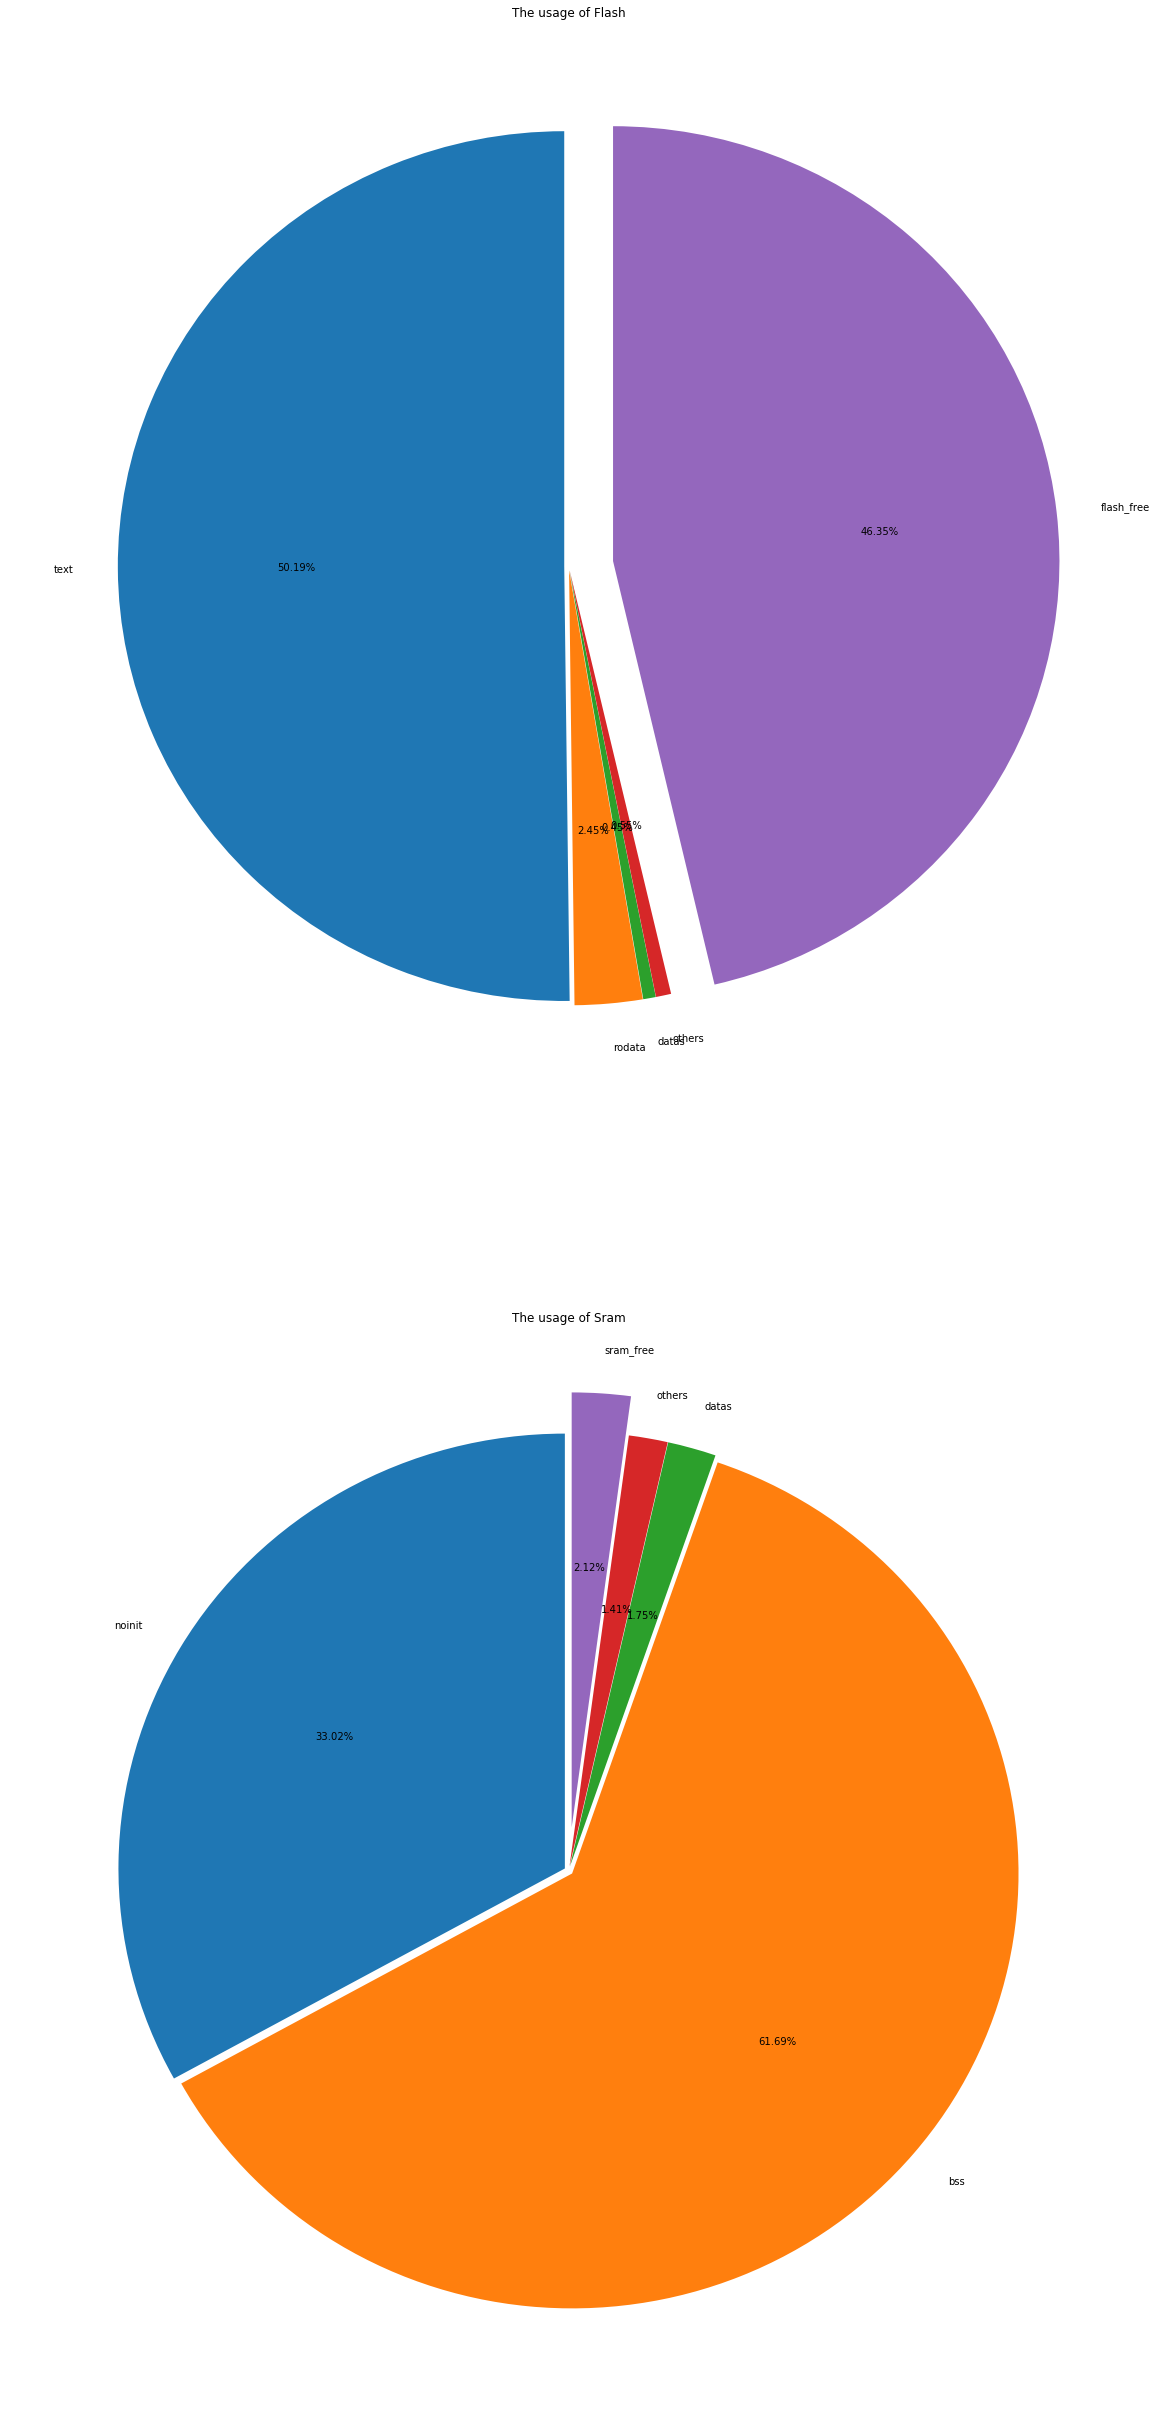

In [91]:
print 'Total FLASH usage: %d/%d' % (elf_data['flash_size'], elf_data['flash_capacity'])
print 'Total SRAM usage: %d/%d' % (elf_data['sram_size'], elf_data['sram_capacity'])

fig, ax = plt.subplots()

plt.subplot(2, 1, 1)
plt.pie(flash_sizes, explode=flash_explode, labels=flash_labels, autopct='%.2f%%', shadow=False, startangle=90)
plt.title('The usage of Flash')

plt.subplot(2, 1, 2)
plt.pie(sram_sizes, explode=sram_explode, labels=sram_labels, autopct='%.2f%%', shadow=False, startangle=90)
plt.title('The usage of Sram')

fig.set_size_inches(20, 44)
plt.show()

In [92]:
for section in section_data:
    print '\n Section', section_data[section]['name'], 'info: Size =', section_data[section]['size'], ', Location:(', 'FLASH,' if section_data[section]['flash'] else '', 'SRAM' if section_data[section]['sram'] else '', ')'
    print section_data[section]['symbol_data'].head(top_counts)
    section_data[section]['name'] = section_data[section]['name'].strip('.') #为了兼容Windows下文件名不能以'.'开头
    section_data[section]['symbol_data'].to_csv('%s/%s.csv' % (elf_summary, section_data[section]['name']))


 Section _k_sem_area info: Size = 100 , Location:( FLASH, SRAM )
      size   address section                     name
4292    20  0001271c      11         recv_malloc_full
2186    20  00012730      11             startup_sync
2645    20  000126f4      11            network_event
4208    20  00012708      11             ping_timeout
4976    20  00012744      11            zping_timeout
11       0  000126f4      11                         
4766     0  00012758      11       _k_mbox_list_start
4596     0  00012758      11        _k_mutex_list_end
4649     0  00012758      11        _k_event_list_end
4652     0  00012758      11       _k_task_list_start
4704     0  00012758      11      _k_mutex_list_start
4881     0  00012758      11        _k_stack_list_end
4875     0  00012758      11         _k_pipe_list_end
4512     0  00012758      11       _k_pipe_list_start
4992     0  00012758      11          _k_sem_list_end
5006     0  00012758      11  _k_task_list_idle_start
5031     0  0001